In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
print('Done')

Done


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping 
from keras.models import Sequential
from keras.layers import Embedding , Conv1D , MaxPool1D , LSTM , Dense
print('Done')

Done


In [3]:
!git clone https://github.com/am1tyadav/superhero

Cloning into 'superhero'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), 47.06 KiB | 2.35 MiB/s, done.


In [4]:
with open('superhero/superheroes.txt','r') as f:
    data = f.read()
data[:10]

'jumpa\t\ndoc'

In [5]:
tokenizer = Tokenizer( filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~' , split='\n' )

In [6]:
tokenizer.fit_on_texts(data)

In [7]:
char_to_index = tokenizer.word_index
index_to_char = dict((value , key) for key , value in char_to_index.items())

index_to_char

{1: '\t',
 2: 'a',
 3: 'e',
 4: 'r',
 5: 'o',
 6: 'n',
 7: 'i',
 8: ' ',
 9: 't',
 10: 's',
 11: 'l',
 12: 'm',
 13: 'h',
 14: 'd',
 15: 'c',
 16: 'u',
 17: 'g',
 18: 'k',
 19: 'b',
 20: 'p',
 21: 'y',
 22: 'w',
 23: 'f',
 24: 'v',
 25: 'j',
 26: 'z',
 27: 'x',
 28: 'q'}

In [8]:
names = data.splitlines()
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [31]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer.texts_to_sequences(names[0])

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [10]:
def name_to_seq(name):
    return [tokenizer.texts_to_sequences(c)[0][0] for c in name]

In [11]:
name_to_seq(names[0])

[25, 16, 12, 20, 2, 1]

In [12]:
def seq_to_name(seq):
    return ''.join([index_to_char[i] for i in seq if i != 0])

In [13]:
seq_to_name(name_to_seq(names[0]))

'jumpa\t'

In [14]:
sequences = []

for name in names :
    seq = name_to_seq(name)
    if len(seq) >= 2 :
        sequences += [seq[:i] for i in range(2 , len(seq) + 1)]

In [15]:
sequences[:10]

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [16]:
max_len = max([len(x) for x in sequences])
max_len

33

In [17]:
padded_sequences = tf.keras.utils.pad_sequences( sequences , padding = 'pre' , maxlen = max_len )

padded_sequences[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 25, 16],
      dtype=int32)

In [18]:
padded_sequences.shape

(88279, 33)

In [19]:
x , y = padded_sequences[:,:-1] , padded_sequences[:,-1]
[x.shape , y.shape]

[(88279, 32), (88279,)]

In [20]:
X_train , X_test , Y_train , Y_test = train_test_split(x , y , train_size= 0.8 , random_state= 4)

[X_train.shape,Y_train.shape,X_test.shape,Y_test.shape]

[(70623, 32), (70623,), (17656, 32), (17656,)]

In [21]:
num_chars = len(char_to_index.keys()) + 1
num_chars

29

In [22]:
model = Sequential([
                    Embedding(num_chars , 8 , input_length= max_len - 1 ) ,    
                    Conv1D(64 , 5 , strides= 1 , activation= 'tanh' , padding= 'causal') ,
                    MaxPool1D(2) ,
                    LSTM(32) ,
                    Dense(num_chars , activation='softmax')
])

model.compile(
                loss = 'sparse_categorical_crossentropy' ,
                optimizer = 'adam' ,
                metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 8)             232       
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            2624      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 29)                957       
                                                                 
Total params: 16,229
Trainable params: 16,229
Non-trainable params: 0
____________________________________________________

In [23]:
a = model.fit ( X_train , Y_train , validation_data = (X_test,Y_test) , epochs = 50 , verbose = 2 , 
                callbacks= [EarlyStopping(monitor='val_accuracy' , patience = 3)])

Epoch 1/50
2207/2207 - 38s - loss: 2.7322 - accuracy: 0.1930 - val_loss: 2.5689 - val_accuracy: 0.2337 - 38s/epoch - 17ms/step
Epoch 2/50
2207/2207 - 31s - loss: 2.5222 - accuracy: 0.2435 - val_loss: 2.4729 - val_accuracy: 0.2542 - 31s/epoch - 14ms/step
Epoch 3/50
2207/2207 - 30s - loss: 2.4513 - accuracy: 0.2606 - val_loss: 2.4293 - val_accuracy: 0.2650 - 30s/epoch - 13ms/step
Epoch 4/50
2207/2207 - 30s - loss: 2.4051 - accuracy: 0.2739 - val_loss: 2.3939 - val_accuracy: 0.2747 - 30s/epoch - 14ms/step
Epoch 5/50
2207/2207 - 33s - loss: 2.3696 - accuracy: 0.2834 - val_loss: 2.3673 - val_accuracy: 0.2840 - 33s/epoch - 15ms/step
Epoch 6/50
2207/2207 - 31s - loss: 2.3407 - accuracy: 0.2931 - val_loss: 2.3439 - val_accuracy: 0.2901 - 31s/epoch - 14ms/step
Epoch 7/50
2207/2207 - 31s - loss: 2.3144 - accuracy: 0.3035 - val_loss: 2.3245 - val_accuracy: 0.2990 - 31s/epoch - 14ms/step
Epoch 8/50
2207/2207 - 30s - loss: 2.2915 - accuracy: 0.3105 - val_loss: 2.3055 - val_accuracy: 0.3053 - 30s/ep

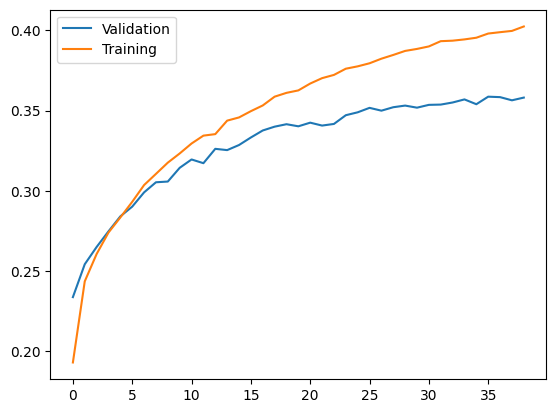

In [24]:
epochs_ran = len(a.history['loss'])

plt.plot(range(0, epochs_ran) , a.history['val_accuracy'] , label = 'Validation')
plt.plot(range(0, epochs_ran) , a.history['accuracy'] , label = 'Training')
plt.legend()
plt.show()

In [25]:
def generate_name(seed):
    for i in range(40):
        seq = name_to_seq(seed)
        padded = tf.keras.utils.pad_sequences( [seq] , padding = 'pre' , maxlen = max_len - 1 , truncating = 'pre')
        pred = model.predict(padded)[0]
        pred_char = index_to_char[np.argmax(pred)]
        seed += pred_char

        if pred_char == '\t' :
            break

    print(seed)

In [26]:
generate_name('te')

1/1 [==============================] - 0s 23ms/step
terra death	


In [27]:
model.save('hero_names.h5')